In [6]:
!date

Tue May 16 14:42:34 PDT 2023


# L$_1$ distances analysis
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [7]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [8]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

from sklearn.metrics import pairwise_distances

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Custom violinplot code
from plotting_funcs import violinplot

# Custom function to fetch genes from Ensembl based on a search word
import gget

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [9]:
# set random seed
np.random.seed(926)

In [10]:
def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load AnnData object - exp and ctrl clustered jointly

In [11]:
adata = anndata.read_h5ad("../../finchseq_data/all_celltype.h5ad")
adata

AnnData object with n_obs × n_vars = 35804 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype', 'connectivity'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Define masks to separate control and experiment datasets:

In [12]:
control_mask = np.logical_or(adata.obs["batch"]=="control1", adata.obs["batch"]=="control2")
experiment_mask = np.logical_or(adata.obs["batch"]=="experiment1", adata.obs["batch"]=="experiment2")

Add new obs column to separate between control and experiment in general, without separating between batches:

In [13]:
adata.obs["batch_g"] = ""

adata.obs.loc[control_mask, "batch_g"] = "control"
adata.obs.loc[experiment_mask, "batch_g"] = "experiment"

adata.obs

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g
barcode,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,13,mural cells 2,0,control
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,3,microglia 1,1,control
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,10,astrocytes 2,3,control
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,1,GABAergic neurons 1,2,control
...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAACTCTT-3,zebrafinch,experiment2,791.999939,3,791.999939,0,glutamatergic neurons 1,undefined 1,experiment
TTTGTTGTCGATCCAA-3,zebrafinch,experiment2,4345.000000,3,4345.000000,2,migrating neuroblasts,9,experiment
TTTGTTGTCTAGATCG-3,zebrafinch,experiment2,1352.000000,3,1352.000000,6,mural / vascular endothelial cells 1,6,experiment


Create columns containing general celltype assignment:

In [14]:
# Create columns containing general celltype assignment - ignoring cluster separation
adata.obs['celltype_g'] = adata.obs['celltype'].str.replace('\d+', '')
adata.obs.head()

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_g
barcode,,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,13,mural cells 2,0,control,mural cells
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,3,microglia 1,1,control,microglia
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,10,astrocytes 2,3,control,astrocytes
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,1,GABAergic neurons 1,2,control,GABAergic neurons


___

# Compute inter-cluster distance (including both exp. and control data)

Group adata by cluster and average across axis 0 (= average the expression of each gene in that cluster):

In [15]:
clusters = np.sort(adata.obs.celltype.values.unique())
means = []
cellcounts_inter = []

for cluster in clusters:
    means.append(nd(adata[adata.obs["celltype"] == cluster].X.mean(axis=0)))
    
    # Collect total number of cells in cluster
    cellcount = len(adata[(adata.obs["celltype"] == cluster)].obs)
    cellcounts_inter.append(cellcount)
    
means = np.array(means)
# Check means shape: should be clusters by genes
means.shape

(22, 22151)

Compute the distance matrix:

In [16]:
cross_cluster_dist = pairwise_distances(means, metric="l1")
cross_cluster_dist.shape

(22, 22)

Plot inter-cluster L$_1$ distances:

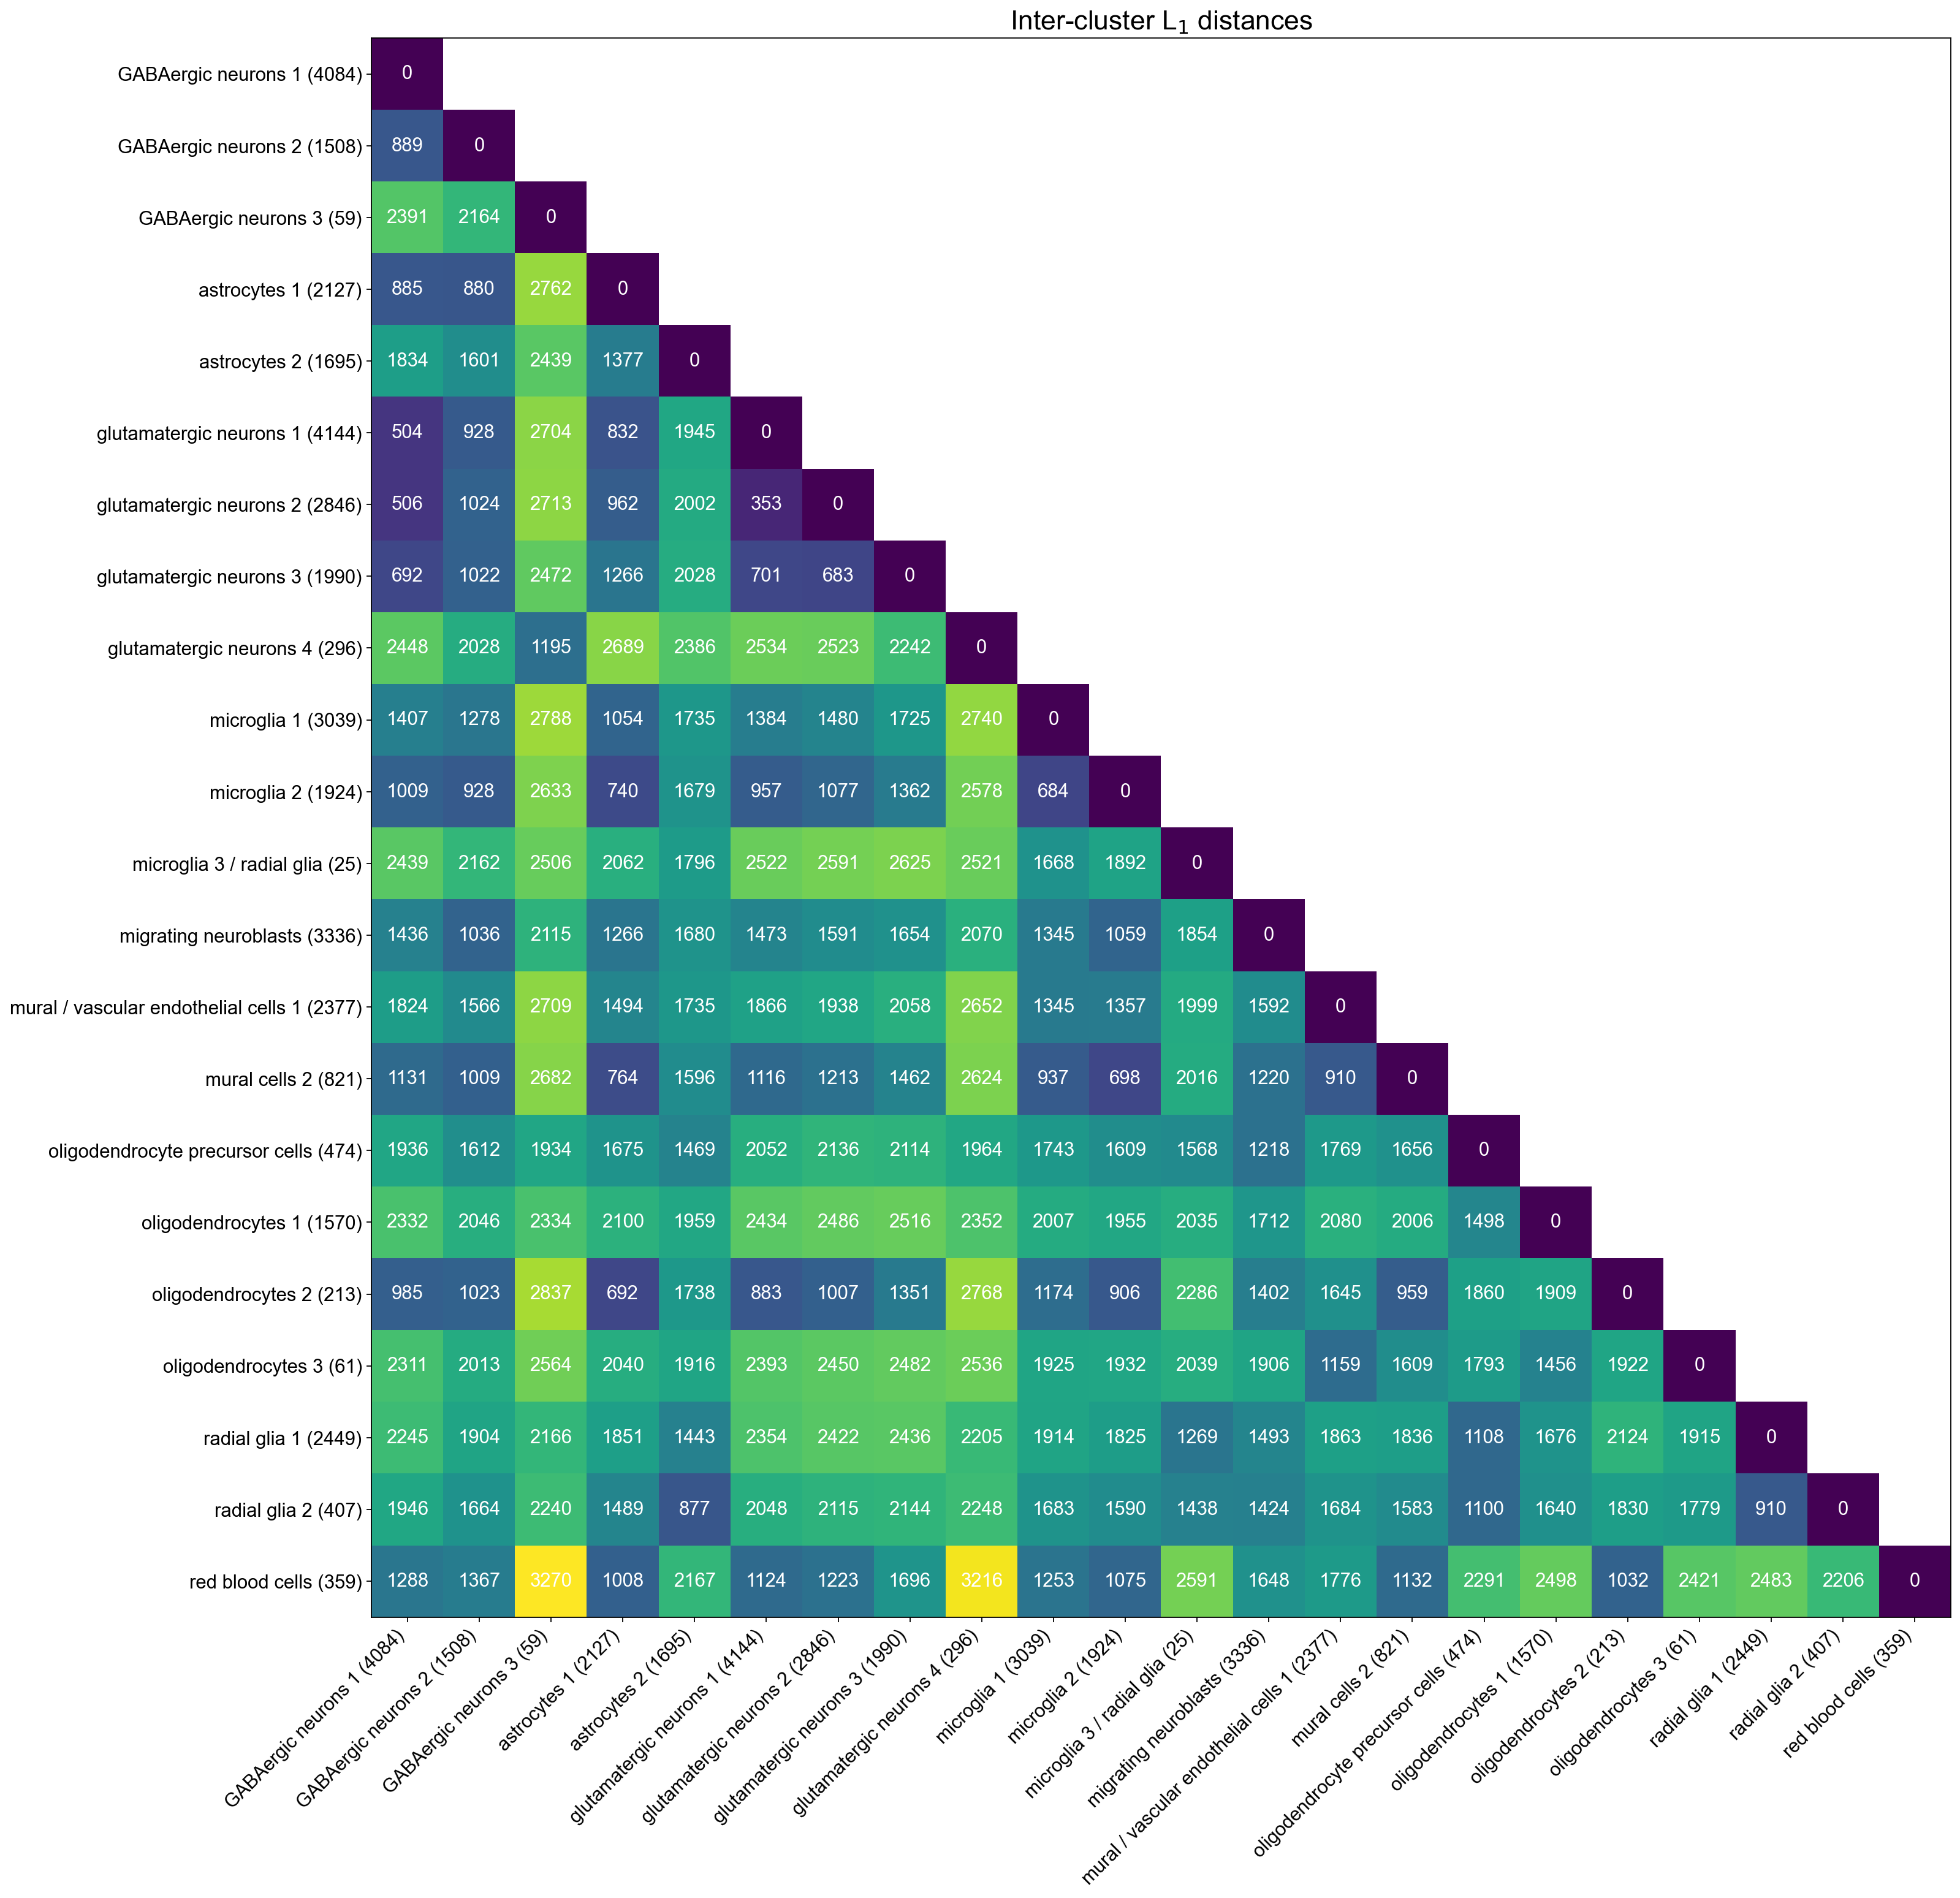

In [17]:
# Create labels containing celltype cluster name and number of cells in that cluster between brackets
celltypes = [i + " " + "(" + str(j) + ")" for i, j in zip(clusters, cellcounts_inter)]

# np.tril only keeps lower triangle to symmetrical matrix (everything else set to 0)
data = np.tril(cross_cluster_dist)
# Convert 0 values to NaN
data[data == 0] = np.nan
# Put back 0s on diagonal (array gets modified in place)
np.fill_diagonal(data, 0)

fontdict = {
    'fontsize': 20,
    'fontweight': None,
}

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(celltypes)))
ax.set_yticks(np.arange(len(celltypes)))
ax.set_xticklabels(celltypes, rotation = 45, ha="right")
ax.set_yticklabels(celltypes)

# Loop over data dimensions and create text annotations of L1 distance rounded to integer
for i in range(len(celltypes)):
    for j in range(len(celltypes)):
        try:
            text = ax.text(j, i, int(data[i, j]), ha="center", va="center", color="w")
        except:
            continue

ax.grid(False)
ax.set_title("Inter-cluster L$_1$ distances", fontdict=fontdict)

fig.tight_layout()
plt.show()

___

# Compute intra-cluster distance between experiment and control data

Group adata by cluster and by condition and average the expression of each gene per condition in that cluster:

In [18]:
exp_ctrl_dists = []
cellcounts_ctrl = []
cellcounts_exp = []

# Get data for one cluster
for cluster in adata.obs.celltype.values.unique():
    m = []
    # Compute the means for control and experiment data in that cluster, respectively
    for condition in ["experiment", "control"]:
        m.append(nd(adata[(adata.obs["celltype"] == cluster) & (adata.obs["batch_g"] == condition)].X.mean(axis=0)))
    
    # Compute distance between control and experiment for each cluster
    dist = pairwise_distances(m, metric="l1")
    
    # Save distance in dict
    # Since we are only comparing two conditions (control versus experiment), the result is a single distance
    exp_ctrl_dists.append(dist[0][1])
    
    # Collect number of cells in cluster from control and experiment
    cellcount_ctrl = len(adata[(adata.obs["celltype"] == cluster) & (adata.obs["batch_g"] == "control")].obs)
    cellcounts_ctrl.append(cellcount_ctrl)
    cellcount_exp = len(adata[(adata.obs["celltype"] == cluster) & (adata.obs["batch_g"] == "experiment")].obs)
    cellcounts_exp.append(cellcount_exp)

Save results in dataframe:

In [19]:
df = pd.DataFrame()
df["cluster"] = adata.obs.celltype.values.unique()
df["ctrl-exp L1 dist"] = exp_ctrl_dists
df["cellcount_ctrl"] = cellcounts_ctrl
df["cellcount_exp"] = cellcounts_exp
# Sort by L1 distances
df = df.sort_values("ctrl-exp L1 dist")
df.head()

,cluster,ctrl-exp L1 dist,cellcount_ctrl,cellcount_exp
2,GABAergic neurons 1,273.621552,2099,1985
8,glutamatergic neurons 1,275.009056,1952,2192
7,glutamatergic neurons 3,295.205458,857,1133
11,glutamatergic neurons 2,297.319812,2005,841
5,red blood cells,334.301783,128,231


Plot L$_1$ distance between control and tetX data for each cluster:

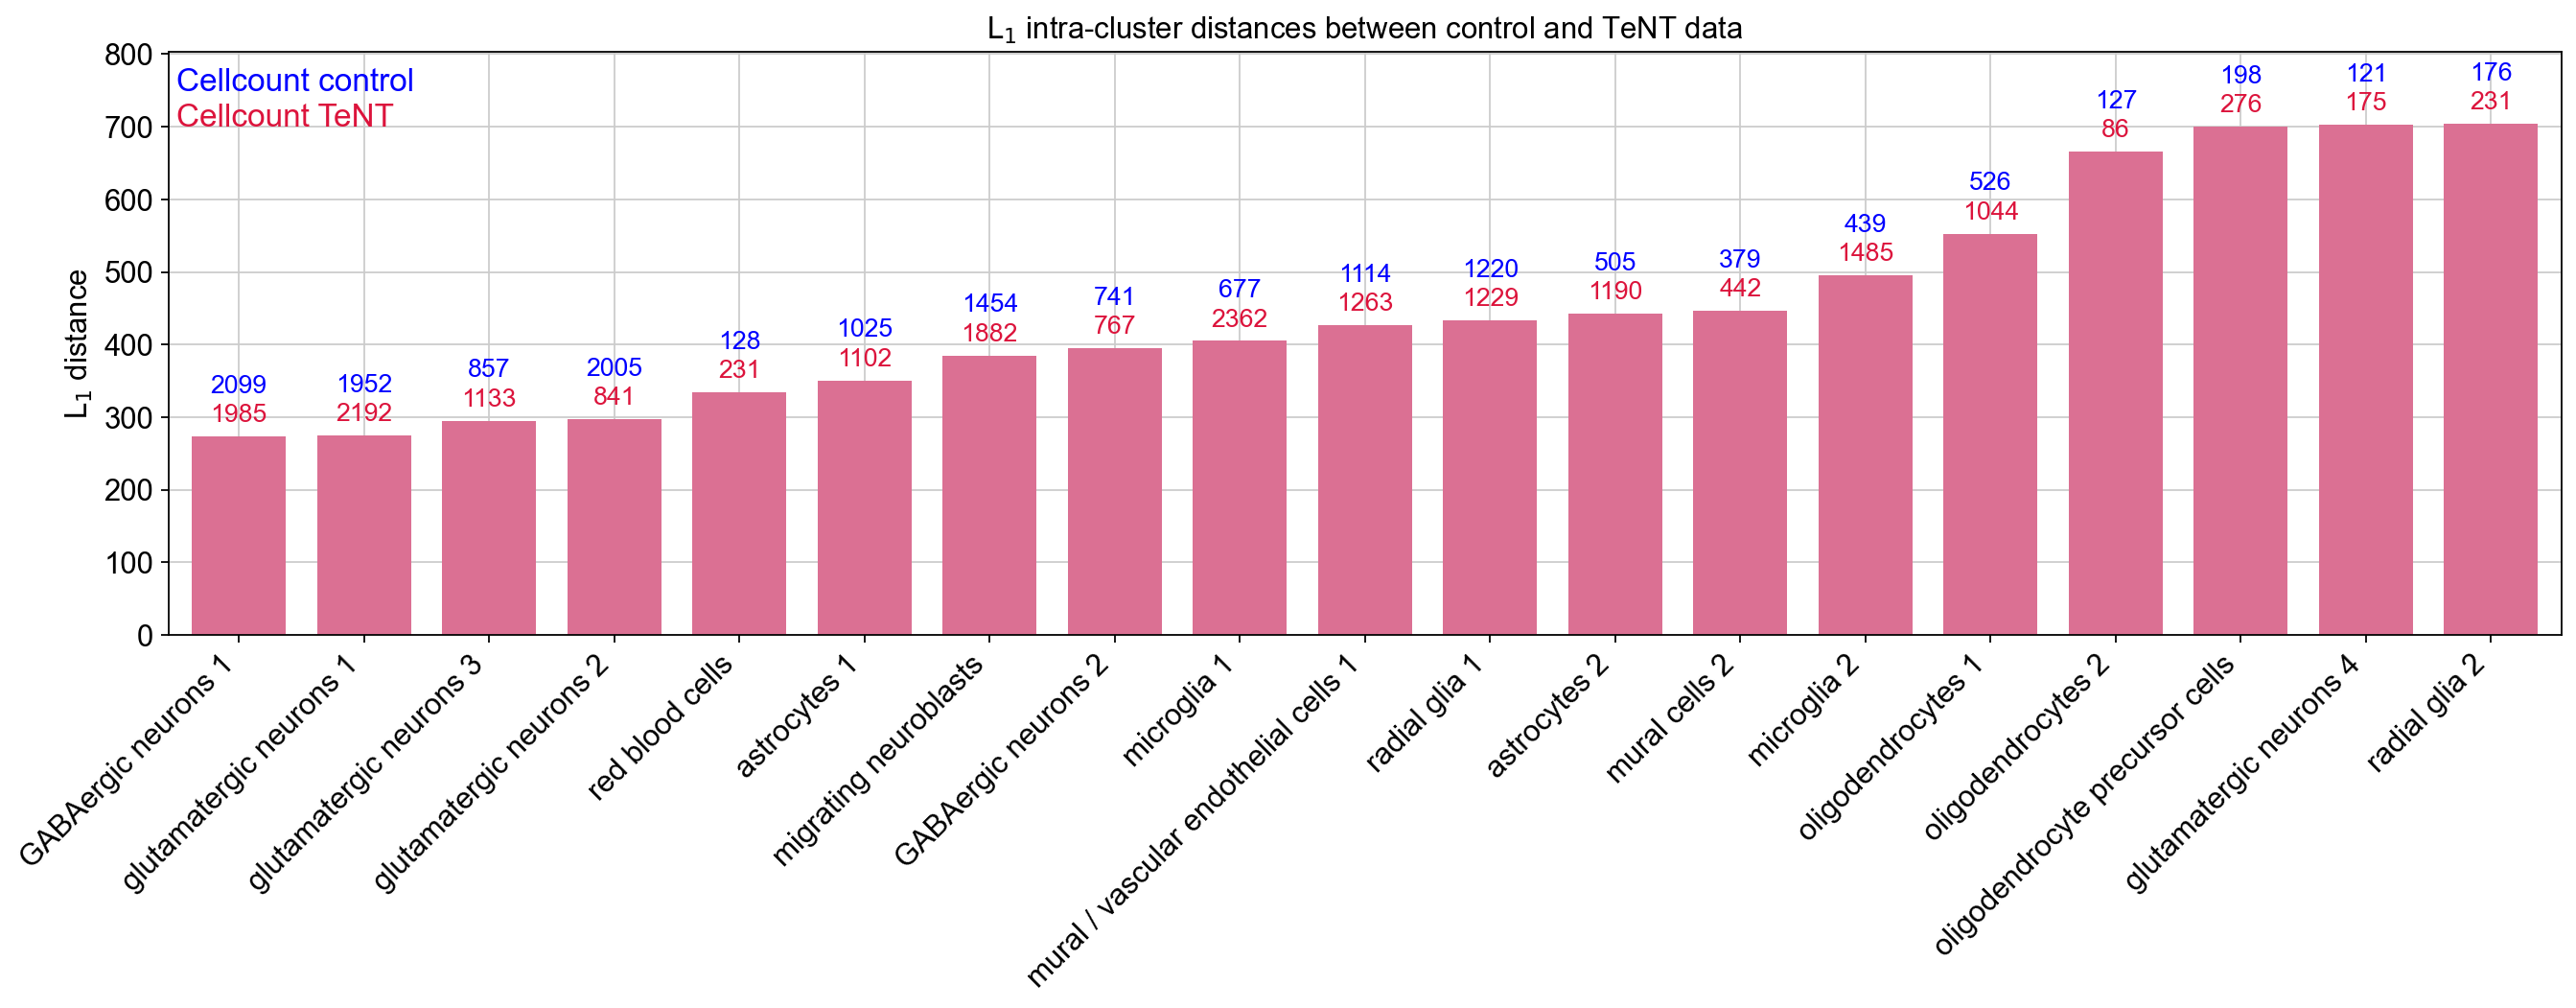

In [45]:
fig, ax = plt.subplots(figsize=(20, 5))
width = 0.75

clusters = df["cluster"].values
dist_ctrl_exp = df["ctrl-exp L1 dist"].values
cellcounts_ctrl = df["cellcount_ctrl"].values
cellcounts_exp = df["cellcount_exp"].values

# Removing last 3 clusters since they have less than 100 cells
ax.bar(
    clusters[:-3],
    dist_ctrl_exp[:-3],
    width,
    color="palevioletred",
)

# Add cluster cellcount above each bar
for index, cc_ctrl in enumerate(cellcounts_ctrl[:-3]):
    ax.text(x = index, 
            y = dist_ctrl_exp[index]+60, 
            s = str(cc_ctrl), 
            size = 12, 
            color = "blue",
            ha='center')
    ax.text(x = index, 
        y = dist_ctrl_exp[index]+20, 
        s = str(cellcounts_exp[index]), 
        size = 12, 
        color = "crimson",
        ha='center')

# Add cellcount legend
ax.text(x = -0.5, 
        y = 750, 
        s = "Cellcount control", 
        size = 15, 
        color = "blue",
        ha='left')
ax.text(x = -0.5, 
        y = 700, 
        s = "Cellcount TeNT", 
        size = 15, 
        color = "crimson",
        ha='left')

ax.set_xticklabels(clusters, rotation=45, ha="right")

ax.set(
    **{
        "title": "L$_1$ intra-cluster distances between control and TeNT data",
        "ylabel": "L$_1$ distance",
#         "xlabel": "Cluster"
    }
)

ax.margins(x=0.01, y=0.14)

ax.set_axisbelow(True)
# ax.grid(False)

fig.show()

___

# Plot distances between clusters and between control and experiment within each cluster

Count occurences of L$_1$ inter-cluster distances:

In [40]:
# Concatenate distance into one list
cluster_dists = np.concatenate(cross_cluster_dist).astype(int)
# Remove all 0s
cluster_dists = cluster_dists[cluster_dists != 0]

# Compute histogram bins
bin_length = 50
inter_bins = int(cluster_dists.max() / bin_length)
inter_counts, inter_bin_edges = np.histogram(cluster_dists, bins=inter_bins)

Count occurences of L$_1$ intra-cluster (ctrl vs exp) distances:

In [41]:
# Convert list to array
exp_ctrl_dists = np.array(exp_ctrl_dists)

# Compute histogram bins
bin_length = 50
intra_bins = int(exp_ctrl_dists.max() / bin_length)
intra_counts, intra_bin_edges = np.histogram(exp_ctrl_dists, bins=intra_bins)

Plot occurences of L$_1$ distances:

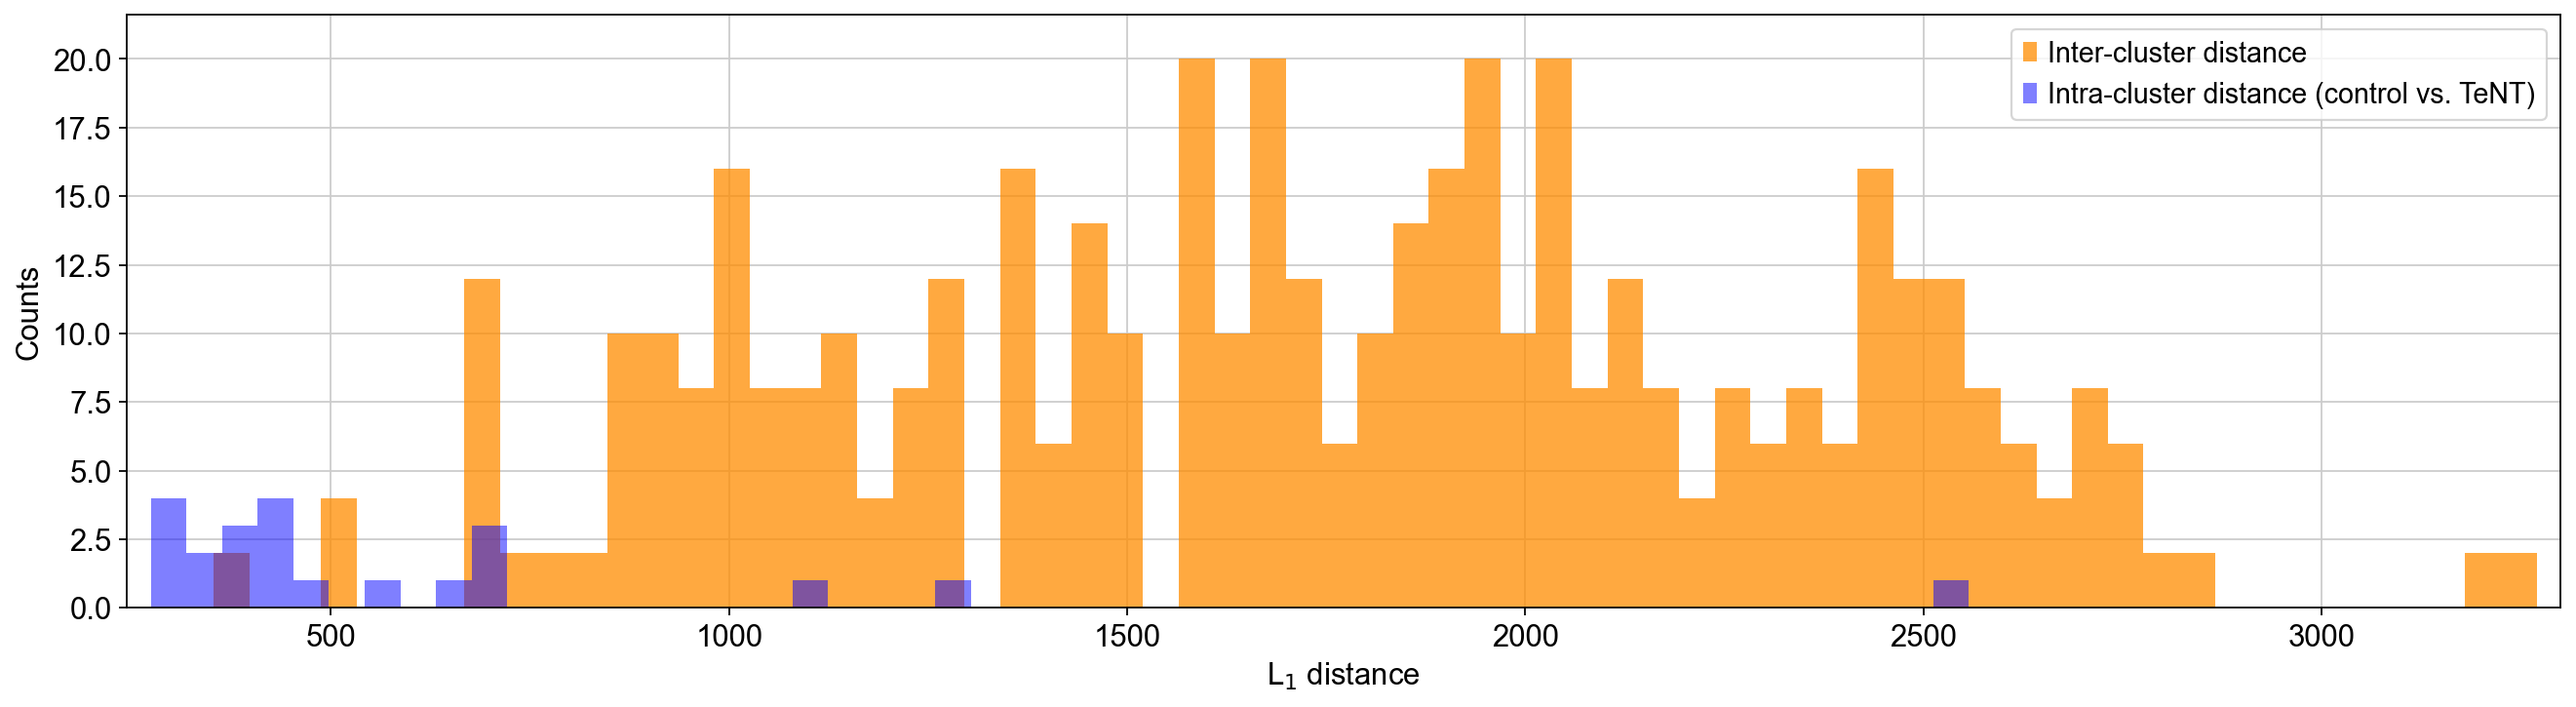

In [46]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(
    inter_bin_edges[:-1],
    inter_counts,
    # Make width of bars equal to distance between bins
    width=inter_bin_edges[1]-inter_bin_edges[0],
    align="edge",
    color="darkorange",
    label="Inter-cluster distance",
    alpha=0.75
)

ax.bar(
    intra_bin_edges[:-1],
    intra_counts,
    # Make width of bars equal to distance between bins
    width=intra_bin_edges[1]-intra_bin_edges[0],
    align="edge",
    color="blue",
    label="Intra-cluster distance (control vs. TeNT)",
    alpha=0.5
)

ax.set(
    **{
        "ylabel": "Counts",
        "xlabel": "L$_1$ distance"
    }
)

ax.legend()

ax.margins(x=0.01, y=0.08)

ax.set_axisbelow(True)
# ax.grid(False)

fig.show()

Plot frequency instead of total counts:

In [47]:
# Compute frequency
inter_freq = inter_counts / inter_counts.sum()
intra_freq = intra_counts / intra_counts.sum()

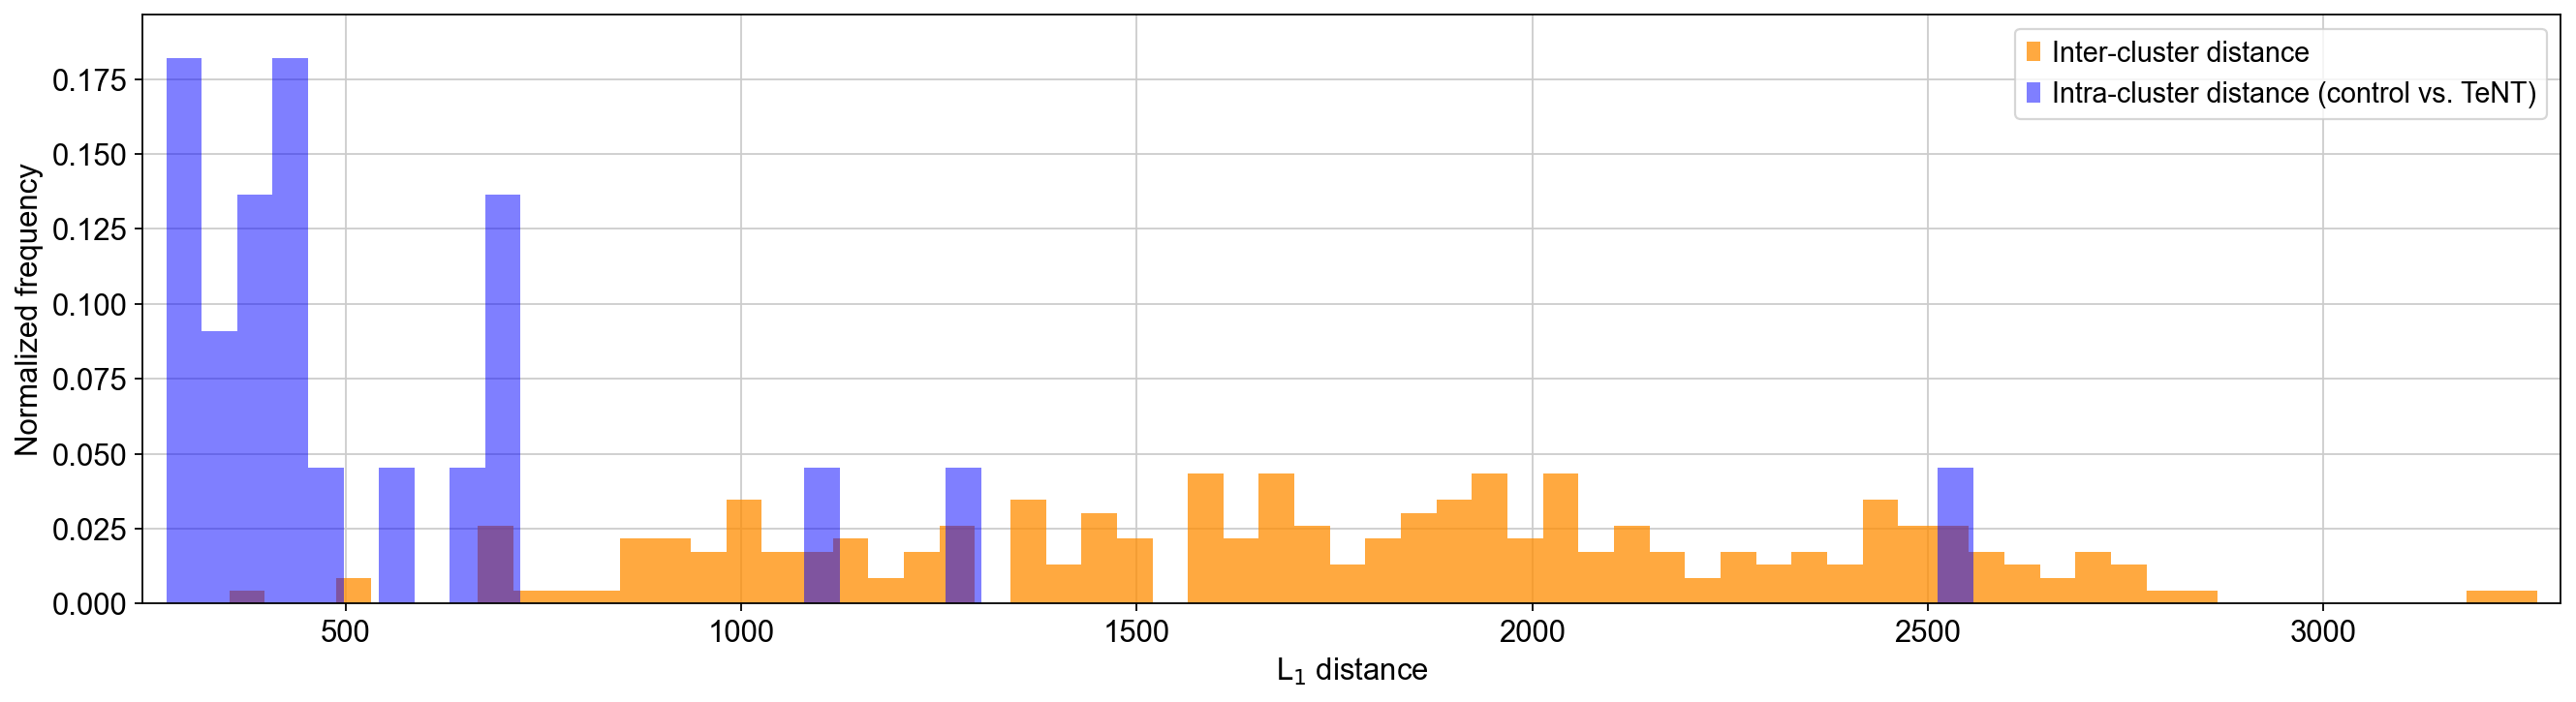

In [48]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(
    inter_bin_edges[:-1],
    inter_freq,
    # Make width of bars equal to distance between bins
    width=inter_bin_edges[1]-inter_bin_edges[0],
    align="edge",
    color="darkorange",
    label="Inter-cluster distance",
    alpha=0.75
)

ax.bar(
    intra_bin_edges[:-1],
    intra_freq,
    # Make width of bars equal to distance between bins
    width=intra_bin_edges[1]-intra_bin_edges[0],
    align="edge",
    color="blue",
    label="Intra-cluster distance (control vs. TeNT)",
    alpha=0.5
)

ax.set(
    **{
        "ylabel": "Normalized frequency",
        "xlabel": "L$_1$ distance"
    }
)

ax.legend()

ax.margins(x=0.01, y=0.08)

ax.set_axisbelow(True)
# ax.grid(False)

fig.show()

___

# Load data - exp and ctrl clustered separately

Load experiment data and add identifiers:

In [86]:
adata_exp = anndata.read('../../finchseq_data/exp_celltype.h5ad')

# Mark celltype and connectivity with "e" for experiment
adata_exp.obs["batch_g"] = "experiment"
adata_exp.obs["celltype_sep"] = adata_exp.obs["celltype"].astype(str) + "_e"
adata_exp.obs["connectivity_sep"] = adata_exp.obs["connectivity"].astype(str) + "_e"

Load control data and add identifiers:

In [87]:
adata_ctrl = anndata.read('../../finchseq_data/ctrl_celltype.h5ad')

# Mark celltype and connectivity with "c" for control
adata_ctrl.obs["batch_g"] = "control"
adata_ctrl.obs["celltype_sep"] = adata_ctrl.obs["celltype"].astype(str) + "_c"
adata_ctrl.obs["connectivity_sep"] = adata_ctrl.obs["connectivity"].astype(str) + "_c"

Concatenate control and experiment data:

In [88]:
adata_sep = adata_ctrl.concatenate(adata_exp, 
                             join='outer', 
                             batch_key='batch_index', 
                             batch_categories=None, 
                             uns_merge=None,
                             fill_value=np.nan)

Create columns containing general celltype assignment - ignoring cluster separation:

In [89]:
# Create columns containing general celltype assignment - ignoring cluster separation
adata_sep.obs['celltype_g'] = adata_sep.obs['celltype'].str.replace('\d+', '')
adata_sep.obs.head()

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g,celltype_sep,connectivity_sep,celltype_g
barcode,,,,,,,,,,,,
AAACCCAAGCACTGGA-0-0,zebrafinch,control1,483.000000,0,483.000000,15,mural cells 1,0,control,mural cells 1_c,0_c,mural cells
AAACCCAAGCGTCAAG-0-0,zebrafinch,control1,946.000061,0,946.000061,12,microglia 1,1,control,microglia 1_c,1_c,microglia
AAACCCAAGGTCACAG-0-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control,GABAergic neurons 1_c,2_c,GABAergic neurons
AAACCCAAGTCATTGC-0-0,zebrafinch,control1,1407.000000,0,1407.000000,9,astrocytes 2,3,control,astrocytes 2_c,3_c,astrocytes
AAACCCAAGTGCTACT-0-0,zebrafinch,control1,1060.000000,0,1060.000000,11,GABAergic neurons 2,4,control,GABAergic neurons 2_c,4_c,GABAergic neurons


___

# Compute inter-cluster distance - sep. clustered data

Group adata by cluster and average across axis 0 (= average the expression of each gene in that cluster):

In [90]:
clusters = np.sort(np.unique(adata_sep.obs.celltype_g.values))
means = []
cellcounts_inter = []

for cluster in clusters:
    means.append(nd(adata_sep[adata_sep.obs["celltype_g"] == cluster].X.mean(axis=0)))
    
    # Collect total number of cells in cluster
    cellcount = len(adata_sep[(adata_sep.obs["celltype_g"] == cluster)].obs)
    cellcounts_inter.append(cellcount)
    
means = np.array(means)
# Check means shape: should be clusters by genes
means.shape

(12, 22151)

Compute the distance matrix:

In [91]:
cross_cluster_dist = pairwise_distances(means, metric="l1")
cross_cluster_dist.shape

(12, 12)

Plot inter-cluster L$_1$ distances:

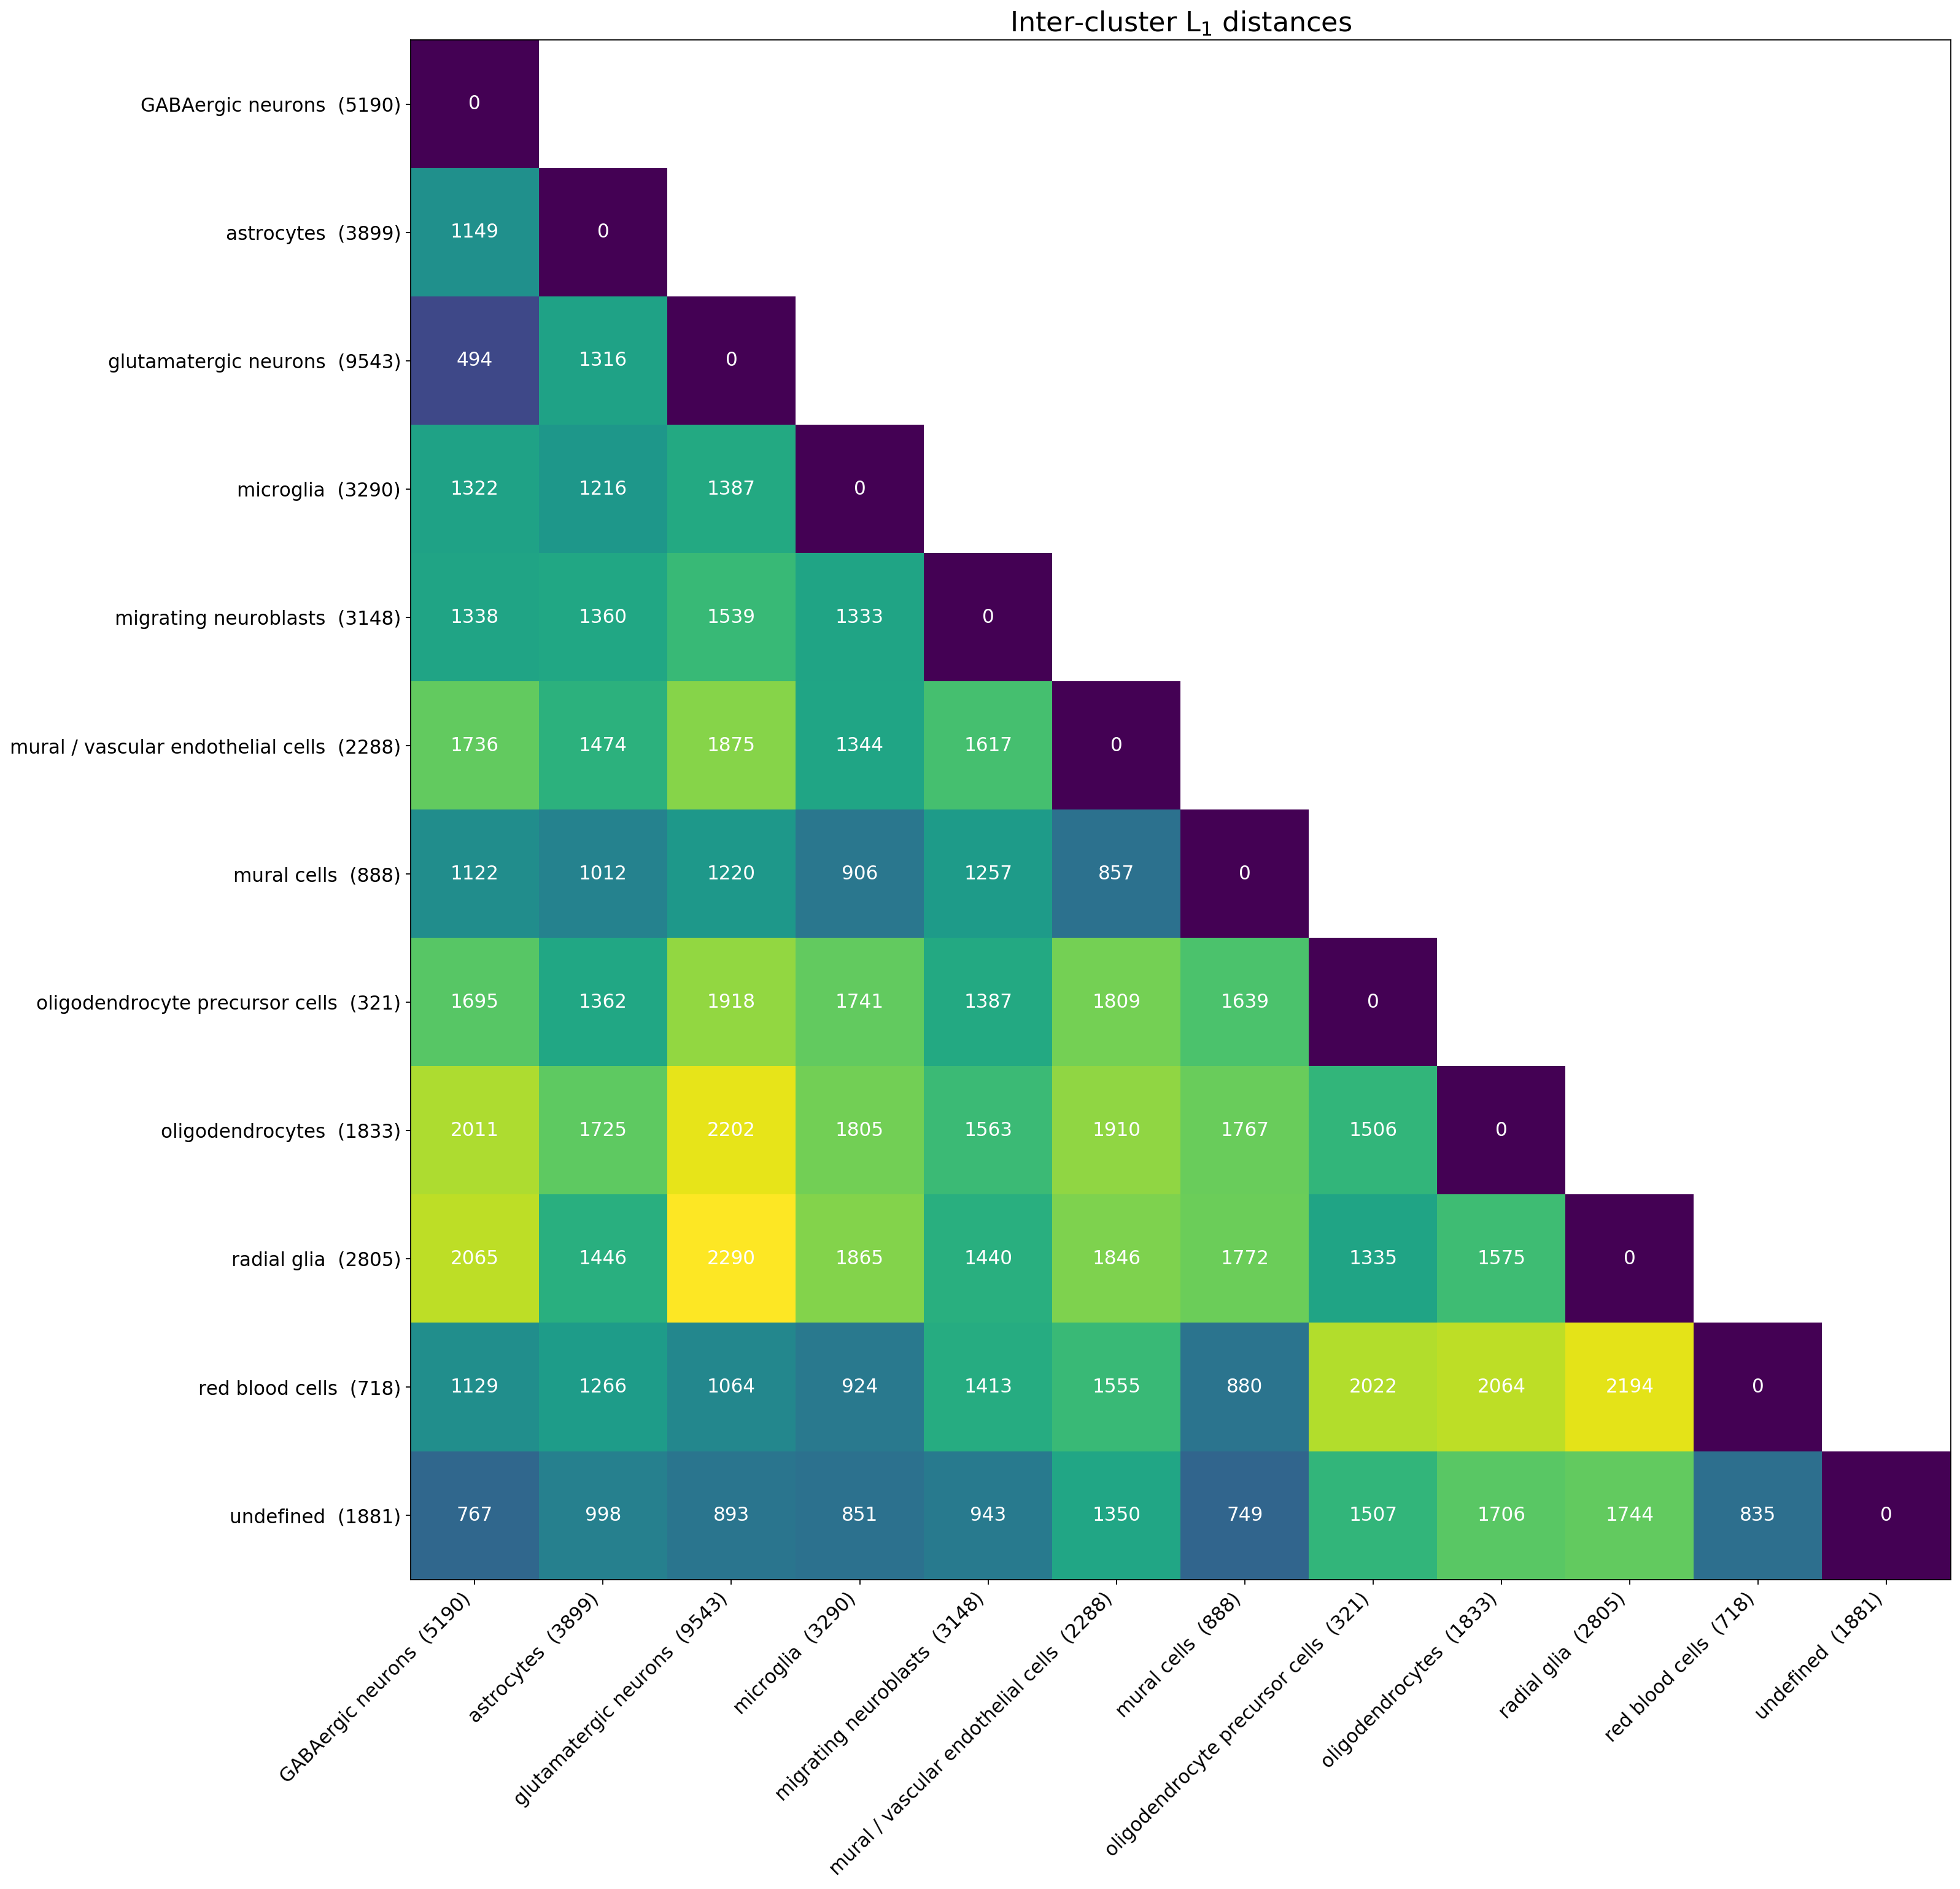

In [92]:
# Create labels containing celltype cluster name and number of cells in that cluster between brackets
celltypes = [i + " " + "(" + str(j) + ")" for i, j in zip(clusters, cellcounts_inter)]

# np.tril only keeps lower triangle to symmetrical matrix (everything else set to 0)
data = np.tril(cross_cluster_dist)
# Convert 0 values to NaN
data[data == 0] = np.nan
# Put back 0s on diagonal (array gets modified in place)
np.fill_diagonal(data, 0)

fontdict = {
    'fontsize': 20,
    'fontweight': None,
}

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(celltypes)))
ax.set_yticks(np.arange(len(celltypes)))
ax.set_xticklabels(celltypes, rotation = 45, ha="right")
ax.set_yticklabels(celltypes)

# Loop over data dimensions and create text annotations of L1 distance rounded to integer
for i in range(len(celltypes)):
    for j in range(len(celltypes)):
        try:
            text = ax.text(j, i, int(data[i, j]), ha="center", va="center", color="w")
        except:
            continue

ax.grid(False)
ax.set_title("Inter-cluster L$_1$ distances", fontdict=fontdict)

fig.tight_layout()
plt.show()

___

# Compute intra-cluster distance - sep. clustered data

Group adata by cluster and by condition and average the expression of each gene per condition in that cluster:

In [93]:
exp_ctrl_dists = []
cellcounts_ctrl = []
cellcounts_exp = []

# Get data for one cluster
for cluster in np.unique(adata_sep.obs.celltype_g.values):
    m = []
    # Compute the means for control and experiment data in that cluster, respectively
    for condition in ["experiment", "control"]:
        m.append(nd(adata_sep[(adata_sep.obs["celltype_g"] == cluster) & (adata_sep.obs["batch_g"] == condition)].X.mean(axis=0)))
    
    # Compute distance between control and experiment for each cluster
    dist = pairwise_distances(m, metric="l1")
    
    # Save distance in dict
    # Since we are only comparing two conditions (control versus experiment), the result is a single distance
    exp_ctrl_dists.append(dist[0][1])
    
    # Collect total number of cells in cluster
    # Collect number of cells in cluster from control and experiment
    cellcount_ctrl = len(adata_sep[(adata_sep.obs["celltype_g"] == cluster) & (adata_sep.obs["batch_g"] == "control")].obs)
    cellcounts_ctrl.append(cellcount_ctrl)
    cellcount_exp = len(adata_sep[(adata_sep.obs["celltype_g"] == cluster) & (adata_sep.obs["batch_g"] == "experiment")].obs)
    cellcounts_exp.append(cellcount_exp)

Save results in dataframe:

In [94]:
df_sep = pd.DataFrame()
df_sep["cluster"] = np.unique(adata_sep.obs.celltype_g.values)
df_sep["ctrl-exp L1 dist"] = exp_ctrl_dists
df_sep["cellcount_ctrl"] = cellcounts_ctrl
df_sep["cellcount_exp"] = cellcounts_exp
# Sort by L1 distances
df_sep = df_sep.sort_values("ctrl-exp L1 dist")
df_sep.head()

,cluster,ctrl-exp L1 dist,cellcount_ctrl,cellcount_exp
0,GABAergic neurons,292.317887,2416,2774
2,glutamatergic neurons,325.992414,4635,4908
4,migrating neuroblasts,375.413993,1379,1769
5,mural / vascular endothelial cells,423.253912,1067,1221
3,microglia,431.221228,694,2596


Plot L$_1$ distance between control and tetX data for each cluster:

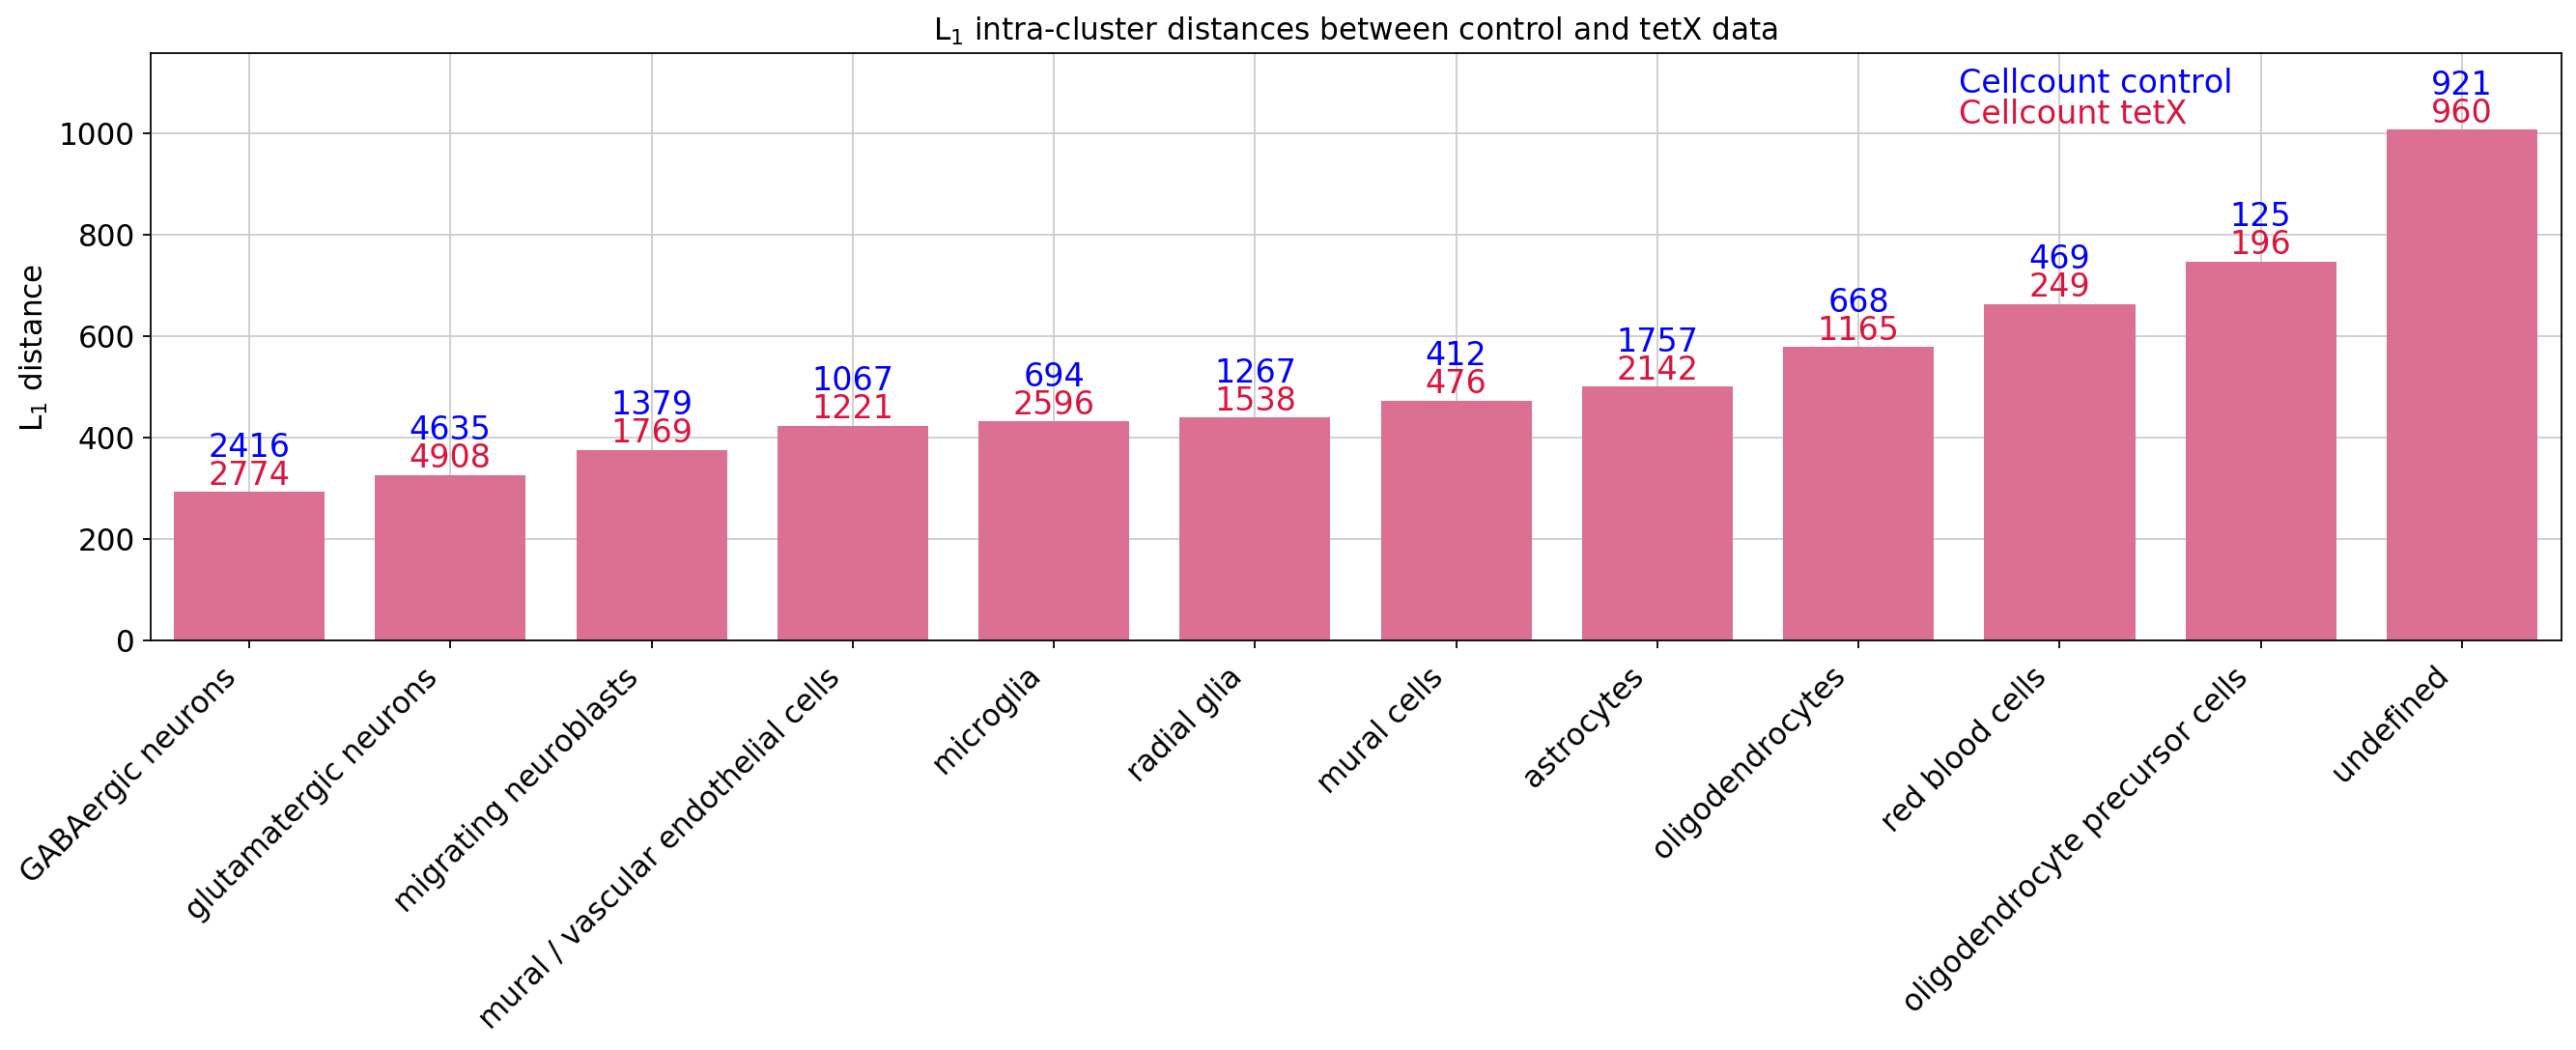

In [95]:
fig, ax = plt.subplots(figsize=(20, 5))
width = 0.75

clusters = df_sep["cluster"].values
dist_ctrl_exp = df_sep["ctrl-exp L1 dist"].values
cellcounts_ctrl = df_sep["cellcount_ctrl"].values
cellcounts_exp = df_sep["cellcount_exp"].values

ax.bar(
    clusters,
    dist_ctrl_exp,
    width,
    color="palevioletred",
)

# Add cluster cellcount above each bar
for index, cc_ctrl in enumerate(cellcounts_ctrl):
    ax.text(x = index, 
            y = dist_ctrl_exp[index]+70, 
            s = str(cc_ctrl), 
            size = 15, 
            color = "blue",
            ha='center')
    ax.text(x = index, 
        y = dist_ctrl_exp[index]+15, 
        s = str(cellcounts_exp[index]), 
        size = 15, 
        color = "crimson",
        ha='center')

# Add cellcount legend
ax.text(x = 8.5, 
        y = 1080, 
        s = "Cellcount control", 
        size = 15, 
        color = "blue",
        ha='left')
ax.text(x = 8.5, 
        y = 1020, 
        s = "Cellcount tetX", 
        size = 15, 
        color = "crimson",
        ha='left')

ax.set_xticklabels(clusters, rotation=45, ha="right")

ax.set(
    **{
        "title": "L$_1$ intra-cluster distances between control and tetX data",
        "ylabel": "L$_1$ distance",
#         "xlabel": "Cluster"
    }
)

ax.margins(x=0.01, y=0.15)

ax.set_axisbelow(True)
# ax.grid(False)

fig.show()

___

# Plot distances between clusters and between control and experiment within each cluster

Count occurences of L 1  inter-cluster distances:

In [96]:
# Concatenate distance into one list
cluster_dists = np.concatenate(cross_cluster_dist).astype(int)
# Remove all 0s
cluster_dists = cluster_dists[cluster_dists != 0]

# Compute histogram bins
bin_length = 50
inter_bins = int(cluster_dists.max() / bin_length)
inter_counts, inter_bin_edges = np.histogram(cluster_dists, bins=inter_bins)

Count occurences of L$_1$ intra-cluster (ctrl vs exp) distances:

In [97]:
# Convert list to array
exp_ctrl_dists = np.array(exp_ctrl_dists)

# Compute histogram bins
bin_length = 50
intra_bins = int(exp_ctrl_dists.max() / bin_length)
intra_counts, intra_bin_edges = np.histogram(exp_ctrl_dists, bins=intra_bins)

Plot occurences of L$_1$ distances:

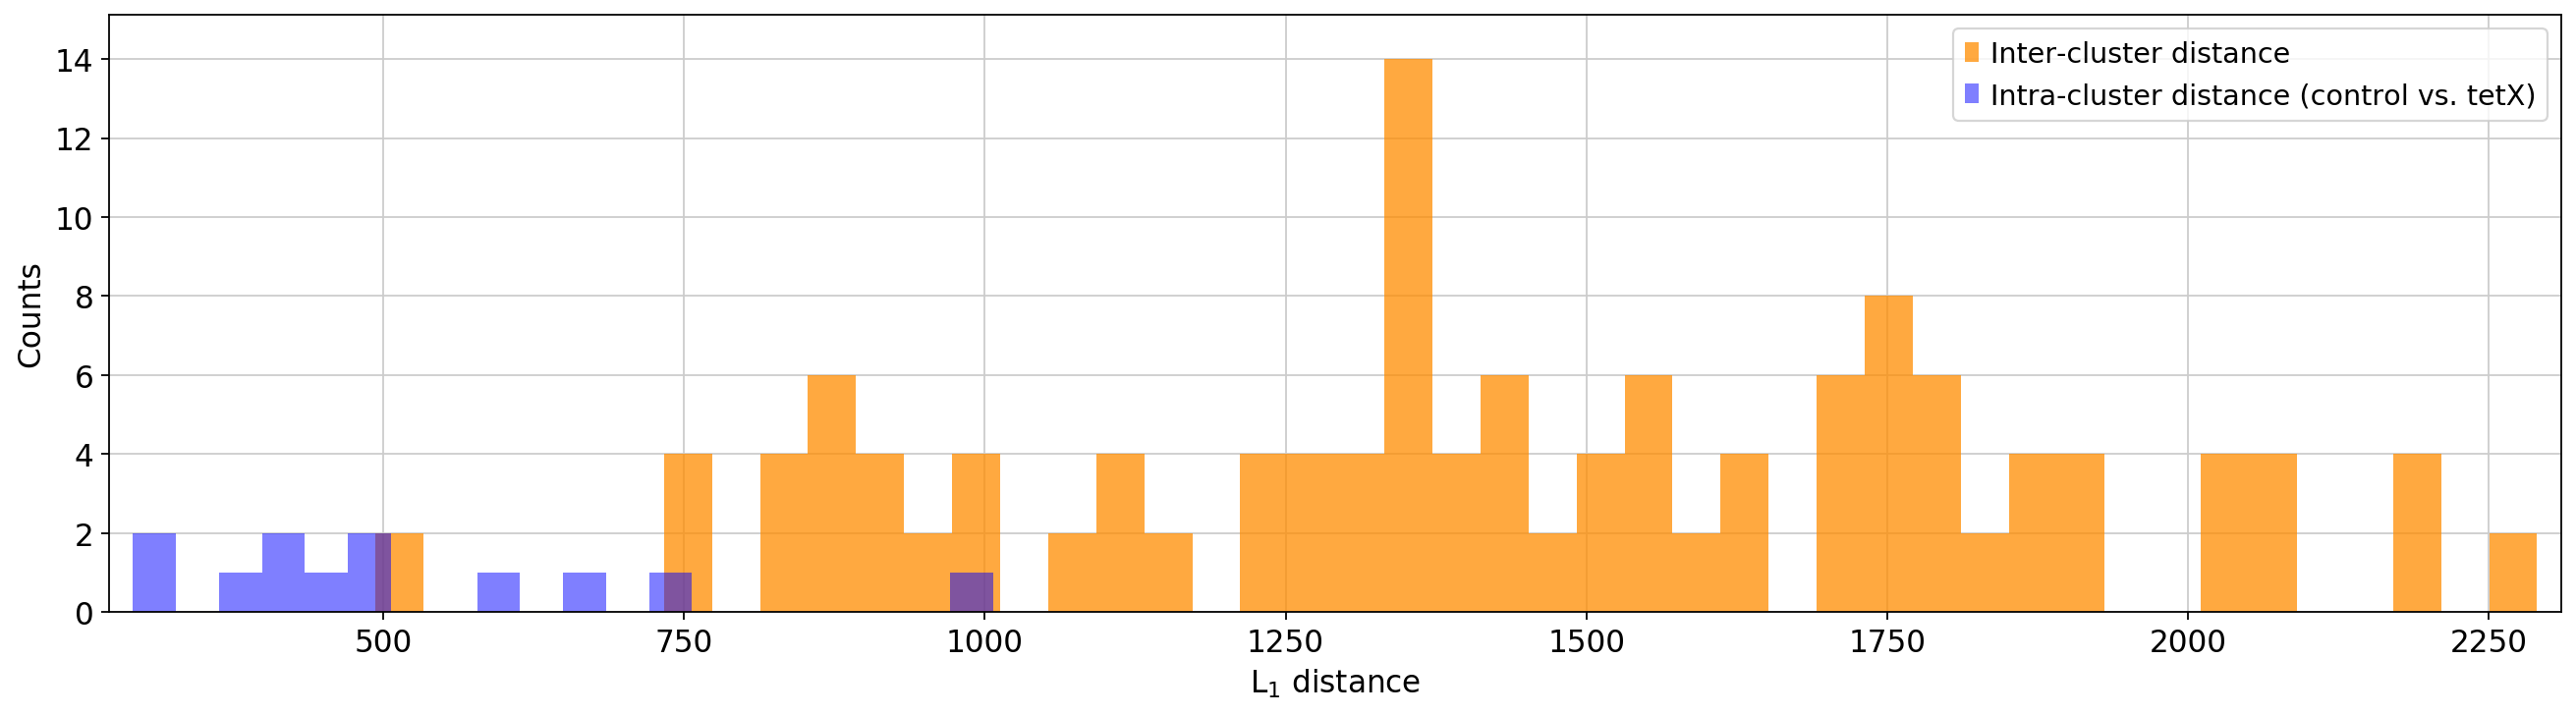

In [98]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(
    inter_bin_edges[:-1],
    inter_counts,
    # Make width of bars equal to distance between bins
    width=inter_bin_edges[1]-inter_bin_edges[0],
    align="edge",
    color="darkorange",
    label="Inter-cluster distance",
    alpha=0.75
)

ax.bar(
    intra_bin_edges[:-1],
    intra_counts,
    # Make width of bars equal to distance between bins
    width=intra_bin_edges[1]-intra_bin_edges[0],
    align="edge",
    color="blue",
    label="Intra-cluster distance (control vs. tetX)",
    alpha=0.5
)

ax.set(
    **{
        "ylabel": "Counts",
        "xlabel": "L$_1$ distance"
    }
)

ax.legend()

ax.margins(x=0.01, y=0.08)

ax.set_axisbelow(True)
# ax.grid(False)

fig.show()

Plot frequency instead of total counts:

In [99]:
# Compute frequency
inter_freq = inter_counts / inter_counts.sum()
intra_freq = intra_counts / intra_counts.sum()

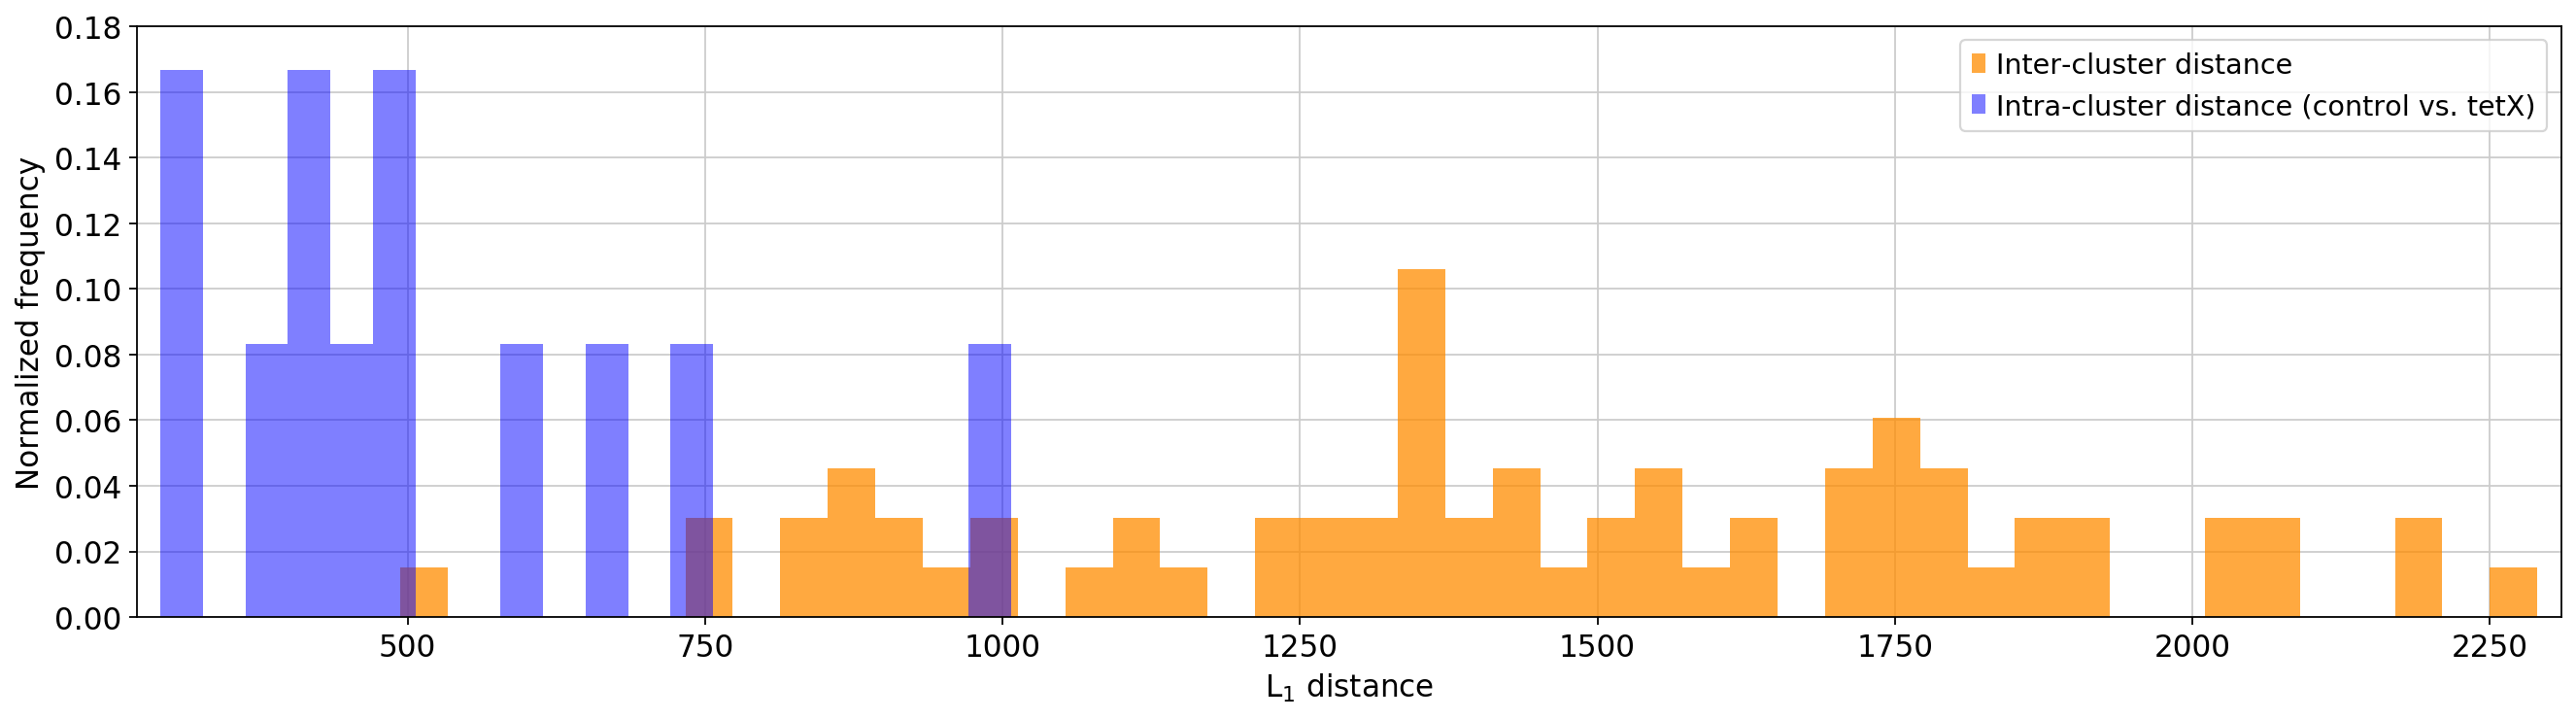

In [100]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(
    inter_bin_edges[:-1],
    inter_freq,
    # Make width of bars equal to distance between bins
    width=inter_bin_edges[1]-inter_bin_edges[0],
    align="edge",
    color="darkorange",
    label="Inter-cluster distance",
    alpha=0.75
)

ax.bar(
    intra_bin_edges[:-1],
    intra_freq,
    # Make width of bars equal to distance between bins
    width=intra_bin_edges[1]-intra_bin_edges[0],
    align="edge",
    color="blue",
    label="Intra-cluster distance (control vs. tetX)",
    alpha=0.5
)

ax.set(
    **{
        "ylabel": "Normalized frequency",
        "xlabel": "L$_1$ distance"
    }
)

ax.legend()

ax.margins(x=0.01, y=0.08)

ax.set_axisbelow(True)
# ax.grid(False)

fig.show()